### Desing Reqs:
- at least 3 pre-processing
- at least 3 classification techniques
- comparrisons
- impact of params

### Ideas:
- Preprocessing
  - subtract by avg
  - 1/-1 bounding, devide by abs(max_val)
  - reframe time series
  - resmaple?
  - denoise?

- ML model on watch data
- ML model on raw data
  - Evaluate fusion "which is more important of recognition"

- Comparrisons
  - F1
  - Ballanced Accuracy
  - runtime
  - confusion matrix



In [ ]:
# Import the dependencies in use
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re
from scipy import signal, interpolate
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, accuracy_score
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
# from tqdm import tqdm
from tqdm.notebook import tqdm, trange
import zipfile

def print_tripple_arr(a1, a2, a3):
  for i in range(max([len(a1), len(a2), len(a3)])):
    x1 = a1[i] if i < len(a1) else None
    x2 = a2[i] if i < len(a2) else None
    x3 = a3[i] if i < len(a3) else None
    print(f"{x1} {x2} {x3}")

In [ ]:
# The datasets are stored in google drive as zip files
# this cell unzips them into the working directory of the colab instance
# goes from ~8Gb zipped to ~40GB unzipped

drive_dir = "/content/drive/MyDrive"
dset_zip = "ExtraSensory.per_uuid_features_labels.zip"
raw_acc_zip = "ExtraSensory.raw_measurements.raw_acc.zip"
watch_acc_zip = "ExtraSensory.raw_measurements.watch_acc.zip"

_test_zip_flag = False

def extract_xtrasensory_labels_to_pwd():
  print(f"extracting {drive_dir}/{dset_zip} to pwd")
  with zipfile.ZipFile(f"{drive_dir}/{dset_zip}", "r") as zip_f:
    zip_f.extractall(path="./lbl")

raw_zip_f = zipfile.ZipFile(f"{drive_dir}/{raw_acc_zip}", "r")
watch_zip_f = zipfile.ZipFile(f"{drive_dir}/{watch_acc_zip}", "r")

if _test_zip_flag:
  bad_raw_zip_f = raw_zip_f.testzip()
  if bad_raw_zip_f:
    print(f"Test raw zip failed on: {bad_raw_zip_f}")
  bad_watch_zip_f = watch_zip_f.testzip()
  if bad_raw_zip_f:
    print(f"Test raw zip failed on: {bad_raw_zip_f}")
else:
  print("skipping zip test")

def uuids_in_zip(zip_f):
  nlist = zip_f.namelist()
  ret_set = set()
  for i, n in enumerate(nlist):
      ret_set.add(f"{str(Path(n).parent)}")
  return list(ret_set)

raw_glob = uuids_in_zip(raw_zip_f)
watch_glob = uuids_in_zip(watch_zip_f)

lbl_glob_str = "./lbl/*.features_labels.csv.gz"
lbl_glob = glob.glob(lbl_glob_str)
if not lbl_glob:
  extract_xtrasensory_labels_to_pwd()
  lbl_glob = glob.glob(lbl_glob_str)

lbl_glob.sort()
raw_glob.sort()
watch_glob.sort()

# print_tripple_arr(lbl_glob, raw_glob, watch_glob)

skipping zip test
extracting /content/drive/MyDrive/ExtraSensory.per_uuid_features_labels.zip to pwd


In [ ]:
'''
This cell cleans the data, some users don't have watch accell data, 
So we make sure that the UUID are consistant accross all the sensors
'''

def stem_arr_from_raw(glob_arr):
  return list(map(
      lambda x: Path(x).name,
      glob_arr
  ))
  
def stem_arr_from_lbl(glob_arr):
  return list(map(
      lambda x: Path(x).name.split(".")[0],
      glob_arr
  ))

def consistant_uuids(raw_uuids, watch_uuids, lbl_uuids):
  ret_arr = []
  for l_uuid in lbl_uuids:
    if l_uuid in raw_uuids and l_uuid in watch_uuids:
      ret_arr.append(l_uuid)
  return ret_arr

def extract_uuids_from_globs(uuids, raw_glob, watch_glob, lbl_glob):
  def _find_substring(x):
    for u in uuids:
      if u in x:
        return True
    return False
  return (
      list(filter(_find_substring, raw_glob)),
      list(filter(_find_substring, watch_glob)),
      list(filter(_find_substring, lbl_glob))
      )

raw_uuids = stem_arr_from_raw(raw_glob)
watch_uuids = stem_arr_from_raw(watch_glob)
lbl_uuids = stem_arr_from_lbl(lbl_glob)

c_uuids = consistant_uuids(raw_uuids, watch_uuids, lbl_uuids)
c_uuids.remove('A5A30F76-581E-4757-97A2-957553A2C6AA')
c_raw_f, c_watch_f, c_lbl_tgz = extract_uuids_from_globs(c_uuids, raw_glob, watch_glob, lbl_glob)
c_raw_f.sort()
c_watch_f.sort()
c_lbl_tgz.sort()
# print_tripple_arr(c_raw_f, c_watch_f, c_lbl_tgz)

In [ ]:
# Gets the proper names of the data labels from an arbitrary peice of sample data
# or a horrible hardcoded hack, incase the files doesn't exist
def get_lbl_coll_arr():
  # cols = pd.read_csv('./lbl/00EABED2-271D-49D8-B599-1D4A09240601.features_labels.csv.gz', compression="gzip").columns.to_list()
  # tmp = list(filter(lambda x: x.startswith("label:"), cols))
  # tmp.insert(0, "timestamp")
  tmp = ['timestamp', 'label:LYING_DOWN', 'label:SITTING', 'label:FIX_walking', 'label:FIX_running', 'label:BICYCLING', 'label:SLEEPING', 'label:LAB_WORK', 'label:IN_CLASS', 'label:IN_A_MEETING', 'label:LOC_main_workplace', 'label:OR_indoors', 'label:OR_outside', 'label:IN_A_CAR', 'label:ON_A_BUS', 'label:DRIVE_-_I_M_THE_DRIVER', 'label:DRIVE_-_I_M_A_PASSENGER', 'label:LOC_home', 'label:FIX_restaurant', 'label:PHONE_IN_POCKET', 'label:OR_exercise', 'label:COOKING', 'label:SHOPPING', 'label:STROLLING', 'label:DRINKING__ALCOHOL_', 'label:BATHING_-_SHOWER', 'label:CLEANING', 'label:DOING_LAUNDRY', 'label:WASHING_DISHES', 'label:WATCHING_TV', 'label:SURFING_THE_INTERNET', 'label:AT_A_PARTY', 'label:AT_A_BAR', 'label:LOC_beach', 'label:SINGING', 'label:TALKING', 'label:COMPUTER_WORK', 'label:EATING', 'label:TOILET', 'label:GROOMING', 'label:DRESSING', 'label:AT_THE_GYM', 'label:STAIRS_-_GOING_UP', 'label:STAIRS_-_GOING_DOWN', 'label:ELEVATOR', 'label:OR_standing', 'label:AT_SCHOOL', 'label:PHONE_IN_HAND', 'label:PHONE_IN_BAG', 'label:PHONE_ON_TABLE', 'label:WITH_CO-WORKERS', 'label:WITH_FRIENDS']
  return tmp

def resample_sample(np_arr, to_num_samples):
  '''
  Resample data with scipy.interpolate.interp1d
  https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html
  Uses spline interpolation to model the signal, and resample evenly with a fixed number of samples
  '''
  NUM_SEC = 20
  FREQ = to_num_samples/NUM_SEC

  og_lin = np.linspace(0, NUM_SEC, np_arr.shape[0])
  resample_lin = np.linspace(0, NUM_SEC, to_num_samples)

  f_interp = interpolate.interp1d(og_lin, np_arr, kind='linear', axis=0)
  return f_interp(resample_lin)


# Takes accelerometer filenames, and a df of lables,
# Reads file data, applies preprocessing (resampling, normalization) 
# Returns tuple with np array of (phone_acc_data, watch_acc_data, labels)
def gen_sample_data(raw_acc_fname, watch_acc_fname):
  raw_acc_np = np.genfromtxt(fname=raw_acc_fname,
               dtype=np.float64,
               delimiter=" ")[:,1:4]
  watch_acc_np = np.genfromtxt(fname=watch_acc_fname,
               dtype=np.float64,
               delimiter=" ")[:,1:4]
  
  # print(f"dtyps: {raw_acc_np.dtype} {raw_acc_np.dtype}")

  if np.any(np.isnan(raw_acc_np)) or np.any(np.isnan(watch_acc_np)):
    print("We might have an issue, one of the np arrays might have NaN in it...")

  # resample
  NUM_SAMPLES = 250
  raw_acc_np = resample_sample(raw_acc_np, NUM_SAMPLES)
  watch_acc_np = resample_sample(watch_acc_np, NUM_SAMPLES)
  
  return (raw_acc_np, watch_acc_np)

def normalize_accel_arr(np_arr):
  '''
  Normalize data with sklearn.preprocessing.StandardScalar
  https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
  Which subtracts the average from each sample, and divides by the standard deviation
  '''
  tmp_lst = []
  for i in range(3):
    tmp_lst.append(preprocessing.StandardScaler().fit_transform(np_arr[:,:,i]))
    
  return np.stack(tmp_lst, axis=2)


def get_samples_from_fs(dat_zip_arr, raw_zip_f, watch_zip_f):
  '''
  This function also cleans data, it lines up timestamps and drops timestamps that don't have a coresponding phone/watch/label data
  It also fills the n/a labels with 0 values
  '''
  lbl_coll_arr = get_lbl_coll_arr()
  lbl_lst = []
  raw_lst = []
  watch_lst = []
  # Itterate over each user
  for lbl_tar_gz, raw_acc_file, watch_acc_file in dat_zip_arr:
    print(f"{lbl_tar_gz} {raw_acc_file} {watch_acc_file}")

    # Create a dataframe with the sample labels
    # Fill any missing labels with 0
    lbl_df = pd.read_csv(lbl_tar_gz, compression="gzip").get(lbl_coll_arr).fillna(0)

    # For each timestamp associated with a sample
    keyerror_count = 0
    good_count = 0
    no_lbl_count = 0
    for i, lbl_sample in lbl_df.iterrows():
      tstamp = str(int(lbl_sample["timestamp"]))
      lbl_np = lbl_sample.drop("timestamp").to_numpy()

      # if not np.any(lbl_np):
      #   no_lbl_count += 1
      #   continue
        
      _raw_f_name = f"{raw_acc_file}/{tstamp}.m_raw_acc.dat"
      _watch_f_name = f"{watch_acc_file}/{tstamp}.m_watch_acc.dat"
      
      try:
        raw_acc_tstamp = raw_zip_f.open(_raw_f_name)
        watch_acc_tstamp = watch_zip_f.open(_watch_f_name)

        tmp = gen_sample_data(raw_acc_tstamp, watch_acc_tstamp)
        
        raw_lst.append(tmp[0])
        watch_lst.append(tmp[1])
        lbl_lst.append(lbl_np)
        good_count += 1
      except KeyError as e:
        keyerror_count += 1
        continue
      
      
    print(f"Done: g:{good_count} stamp_dne:{keyerror_count} ")
    # print(f"Done: g:{good_count} stamp_dne:{keyerror_count} n_lbl:{no_lbl_count}")

  return (
    np.stack(raw_lst),
    np.stack(watch_lst),
    np.stack(lbl_lst)
  )
  # return (
  #   raw_lst,
  #   watch_lst,
  #   lbl_lst,
  # )

# c_raw_f, c_watch_f, c_lbl_tgz
# raw_arr, watch_arr, lbl_arr = get_samples_from_fs(zip(c_lbl_tgz[45:], c_raw_f[45:], c_watch_f[45:]), raw_zip_f, watch_zip_f)
# raw_arr, watch_arr, lbl_arr = get_samples_from_fs(zip(c_lbl_tgz[30:45], c_raw_f[30:45], c_watch_f[30:45]), raw_zip_f, watch_zip_f)
# raw_arr, watch_arr, lbl_arr = get_samples_from_fs(zip(c_lbl_tgz[15:30], c_raw_f[15:30], c_watch_f[15:30]), raw_zip_f, watch_zip_f)
# raw_arr, watch_arr, lbl_arr = get_samples_from_fs(zip(c_lbl_tgz[0:15], c_raw_f[0:15], c_watch_f[0:15]), raw_zip_f, watch_zip_f)
# raw_arr, watch_arr, lbl_arr = get_samples_from_fs(zip(c_lbl_tgz, c_raw_f, c_watch_f), raw_zip_f, watch_zip_f)
# norm_raw_arr = normalize_accel_arr(raw_arr)
# norm_watch_arr = normalize_accel_arr(watch_arr)

def get_clean_npz_from_drive():
  npz_arr = [
    "/content/drive/MyDrive/xsenory_0_14_clean.npz",
    "/content/drive/MyDrive/xsensory_15_29_clean.npz",
    f'{drive_dir}/xsenory_30_44_clean.npz',
    f'{drive_dir}/xsenory_45_end_clean.npz',
  ]

  tmp_w = []
  tmp_r = []
  tmp_l = []
  for f in npz_arr:
    with np.load(f) as d:
      tmp_r.append(d['arr_0'])
      tmp_w.append(d['arr_1'])
      tmp_l.append(d['arr_2'])
  return (
    np.concatenate(tmp_r),
    np.concatenate(tmp_w),
    np.concatenate(tmp_l),
  )

norm_raw_arr, norm_watch_arr, lbl_arr = get_clean_npz_from_drive()



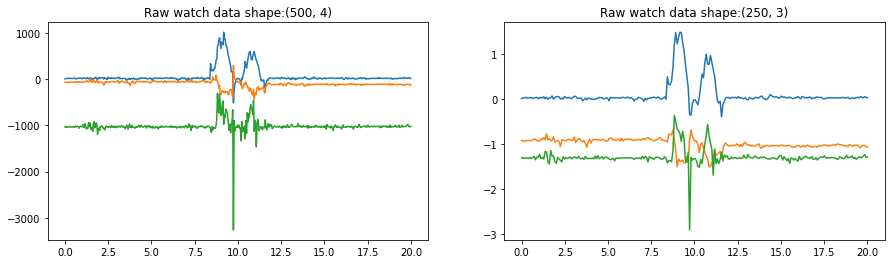

In [ ]:
raw_watch = np.genfromtxt(watch_zip_f.open("watch_acc/00EABED2-271D-49D8-B599-1D4A09240601/1444079431.m_watch_acc.dat")) # This should be sample 4 of the processed data
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,4))
ax1.set_title(f"Raw watch data shape:{raw_watch.shape}")
ax1.plot(np.linspace(0,20,len(raw_watch[:,0])), raw_watch[:,1:4])
ax2.set_title(f"Raw watch data shape:{norm_watch_arr[4].shape}")
ax2.plot(np.linspace(0,20,250), norm_watch_arr[4])
plt.show()

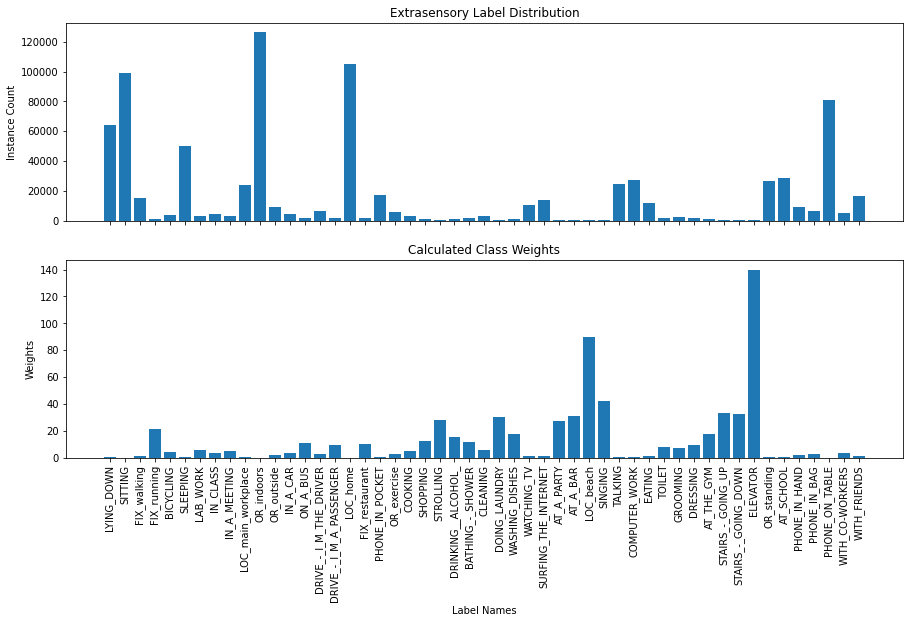

In [ ]:
lbl_count = np.sum(lbl_arr, axis=0)
cols = get_lbl_coll_arr()
cols.pop(0)
cols = list(map(lambda x: x.replace('label:', ''), cols))

num_labels = np.sum(lbl_count) 
lbl_weights = num_labels / (len(lbl_count) * lbl_count)
lbl_weights[lbl_weights == np.inf] = np.max(lbl_weights[lbl_weights != np.inf])

fig, (ax1, ax2) = plt.subplots(2, figsize=(15,8))
# plt.figure(figsize=(25, 5))
ax1.set_title("Extrasensory Label Distribution")
ax1.set_ylabel("Instance Count")
ax1.bar(cols, lbl_count)
# ax1.set_xticklabels(cols,rotation='vertical')
# ax1.set_xticklabels(cols,visible=False)
ax1.set_xticklabels([])
ax2.set_title("Calculated Class Weights")
ax2.bar(cols, lbl_weights)
ax2.set_ylabel("Weights")
ax2.set_xlabel("Label Names")
ax2.set_xticklabels(cols,rotation='vertical')
plt.savefig(f"{drive_dir}/xsenory_dset_stats.pdf", bbox_inches = "tight")
plt.show()
print(f"Num Samples: {len(norm_raw_arr)} {len(norm_watch_arr)} {len(lbl_arr)}")
print(lbl_count)
print(lbl_weights)

In [ ]:
BATCH_SIZE = 512
NUM_EPOCHS = 50
ITERS_PER_EVAL = 100
LEARNING_RATE= 1e-3


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')

class MyDataset(Dataset):
  def __init__(self, raw, watch, lbl):
    self.raw = raw.transpose(0,2,1).astype(np.float32)
    self.watch = watch.transpose(0,2,1).astype(np.float32)
    self.lbl = lbl.astype(np.float32)

  def __len__(self):
      return len(self.lbl)
    
  def __getitem__(self, idx):
    return{
        'raw':self.raw[idx],
        'watch':self.watch[idx],
        'lbl':self.lbl[idx],
    }

raw_train, raw_test, watch_train, watch_test, lbl_train, lbl_test = train_test_split(norm_raw_arr, norm_watch_arr, lbl_arr)

train_dset = MyDataset(raw_train, watch_train, lbl_train)
test_dset = MyDataset(raw_test, watch_test, lbl_test)

train_dataloader = DataLoader(train_dset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dset, batch_size=BATCH_SIZE)

In [ ]:
class BigActivityRecogCNN(nn.Module):
    def __init__(self):
        super(BigActivityRecogCNN, self).__init__()
        self.raw_cnn_stack = nn.Sequential(
            nn.Conv1d(3, 12, 5),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv1d(12, 24, 5),
            nn.ReLU(),
            nn.Dropout(),
        )
        self.watch_cnn_stack = nn.Sequential(
            nn.Conv1d(3, 12, 5),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv1d(12, 24, 5),
            nn.ReLU(),
            nn.Dropout(),
        )
        self.linear_relu_stack = nn.Sequential(
          nn.Flatten(),
          nn.Linear(11616, 1024),
          nn.ReLU(),
          nn.Dropout(),
          nn.Linear(1024,51),
          nn.Sigmoid(),
        )
    def forward(self, raw, watch):
      conv_raw = self.raw_cnn_stack(raw)
      conv_watch = self.watch_cnn_stack(watch)
      rw_combined = torch.cat((conv_raw, conv_watch), dim=1)
      out = self.linear_relu_stack(rw_combined)
      return out

class ActivityRecog2DCNN(nn.Module):
    def __init__(self):
        super(ActivityRecog2DCNN, self).__init__()
        self.raw_cnn_stack = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.ReLU(),
            nn.Dropout(),
        )
        self.watch_cnn_stack = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.ReLU(),
            nn.Dropout(),
        )
        self.linear_relu_stack = nn.Sequential(
          nn.Flatten(),
          nn.Linear(15872, 1024),
          nn.ReLU(),
          nn.Dropout(),
          nn.Linear(1024, 51),
          nn.Sigmoid(),
        )
    def forward(self, raw, watch):
      conv_raw = self.raw_cnn_stack(torch.reshape(raw, (raw.shape[0], 1, raw.shape[1], raw.shape[2])))
      conv_watch = self.watch_cnn_stack(torch.reshape(watch, (watch.shape[0], 1, watch.shape[1], watch.shape[2])))
      rw_combined = torch.cat((conv_raw, conv_watch), dim=2)
      out = self.linear_relu_stack(rw_combined)
      return out

class BigActivityRecogCNN_1a2D(nn.Module):
    def __init__(self):
        super(BigActivityRecogCNN_1a2D, self).__init__()
        self.raw_cnn_stack = nn.Sequential(
            nn.Conv2d(1, 8, (1,3)),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv2d(8, 16, 3),
            nn.ReLU(),
            nn.Dropout(),
        )
        self.watch_cnn_stack = nn.Sequential(
            nn.Conv2d(1, 8, (1,3)),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv2d(8, 16, 3),
            nn.ReLU(),
            nn.Dropout(),
        )
        self.linear_relu_stack = nn.Sequential(
          nn.Flatten(),
          nn.Linear(7872, 1024),
          nn.ReLU(),
          nn.Dropout(),
          nn.Linear(1024, 51),
          nn.Sigmoid(),
        )
    def forward(self, raw, watch):
      conv_raw = self.raw_cnn_stack(torch.reshape(raw,(raw.shape[0], 1, raw.shape[1], raw.shape[2])))
      conv_watch = self.watch_cnn_stack(torch.reshape(watch,(watch.shape[0], 1, watch.shape[1], watch.shape[2])))
      rw_combined = torch.cat((conv_raw, conv_watch), dim=2)
      out = self.linear_relu_stack(rw_combined)
      return out

class BigActivityRecogCNN_withPooling(nn.Module):
    def __init__(self):
        super(BigActivityRecogCNN_withPooling, self).__init__()
        self.raw_cnn_stack = nn.Sequential(
            nn.Conv1d(3, 32, 5),
            nn.ReLU(),
            nn.MaxPool1d(3),
            nn.Dropout(),
            nn.Conv1d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool1d(3),
            nn.Dropout(),
        )
        self.watch_cnn_stack = nn.Sequential(
            nn.Conv1d(3, 32, 5),
            nn.ReLU(),
            nn.MaxPool1d(3),
            nn.Dropout(),
            nn.Conv1d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool1d(3),
            nn.Dropout(),
        )
        self.linear_relu_stack = nn.Sequential(
          nn.Flatten(),
          nn.Linear(3328, 1024),
          nn.ReLU(),
          nn.Dropout(),
          nn.Linear(1024, 51),
          nn.Sigmoid(),
        )

    def forward(self, raw, watch):
      conv_raw = self.raw_cnn_stack(raw)
      conv_watch = self.watch_cnn_stack(watch)
      rw_combined = torch.cat((conv_raw, conv_watch), dim=1)
      out = self.linear_relu_stack(rw_combined)
      return out

class BigActivityRecogCNN_Spicy(nn.Module):
    def __init__(self):
        super(BigActivityRecogCNN_Spicy, self).__init__()
        self.raw_cnn_stack = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.ReLU(),
            nn.Dropout(),
        )
        self.watch_cnn_stack = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.ReLU(),
            nn.Dropout(),
        )
        self.linear_relu_stack = nn.Sequential(
          nn.Conv1d(64, 64, 5),
          nn.ReLU(),
          nn.Dropout(),
          nn.MaxPool1d(3),
          nn.Flatten(),
          nn.Linear(5184, 1024),
          nn.ReLU(),
          nn.Dropout(),
          nn.Linear(1024, 51),
          nn.Sigmoid(),
        )

    def forward(self, raw, watch):
      conv_raw = self.raw_cnn_stack(torch.reshape(raw,(raw.shape[0], 1, raw.shape[1], raw.shape[2])))
      conv_watch = self.watch_cnn_stack(torch.reshape(watch,(raw.shape[0], 1, watch.shape[1], watch.shape[2])))
      rw_combined = torch.cat((conv_raw, conv_watch), dim=1)
      # print(rw_combined.shape)
      out = self.linear_relu_stack(torch.reshape(rw_combined,(rw_combined.shape[0], rw_combined.shape[1], rw_combined.shape[3])))
      return out

class BigActivityRecogCNN_withPooling_Fixed(nn.Module):
    def __init__(self):
        super(BigActivityRecogCNN_withPooling_Fixed, self).__init__()
        self.raw_cnn_stack = nn.Sequential(
            nn.Conv1d(3, 32, 5),
            nn.MaxPool1d(3),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv1d(32, 64, 5),
            nn.MaxPool1d(3),
            nn.ReLU(),
            nn.Dropout(),
        )
        self.watch_cnn_stack = nn.Sequential(
            nn.Conv1d(3, 32, 5),
            nn.MaxPool1d(3),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv1d(32, 64, 5),
            nn.MaxPool1d(3),
            nn.ReLU(),
            nn.Dropout(),
        )
        self.linear_relu_stack = nn.Sequential(
          nn.Flatten(),
          nn.Linear(3328, 1024),
          nn.ReLU(),
          nn.Dropout(),
          nn.Linear(1024, 51),
          nn.Sigmoid(),
        )

    def forward(self, raw, watch):
      conv_raw = self.raw_cnn_stack(raw)
      conv_watch = self.watch_cnn_stack(watch)
      rw_combined = torch.cat((conv_raw, conv_watch), dim=1)
      out = self.linear_relu_stack(rw_combined)
      return out

# model = ActivityRecogCNN().to(device)
model = BigActivityRecogCNN().to(device)
# model = BigActivityRecogCNN_withPooling().to(device)
# model = BigActivityRecogCNN_1a2D().to(device)
# model = ActivityRecog2DCNN().to(device)
# model = BigActivityRecogCNN_Spicy().to(device)
# model = BigActivityRecogCNN_withPooling_Fixed().to(device)
print(model)
model.eval()
model(
    torch.randn((64, 3, 250)).to(device),
    torch.randn((64, 3, 250)).to(device)
)

BigActivityRecogCNN(
  (raw_cnn_stack): Sequential(
    (0): Conv1d(3, 12, kernel_size=(5,), stride=(1,))
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv1d(12, 24, kernel_size=(5,), stride=(1,))
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
  )
  (watch_cnn_stack): Sequential(
    (0): Conv1d(3, 12, kernel_size=(5,), stride=(1,))
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv1d(12, 24, kernel_size=(5,), stride=(1,))
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
  )
  (linear_relu_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=11616, out_features=1024, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1024, out_features=51, bias=True)
    (5): Sigmoid()
  )
)


tensor([[0.4843, 0.5070, 0.4958,  ..., 0.5028, 0.5027, 0.5301],
        [0.5001, 0.5151, 0.5024,  ..., 0.5178, 0.5032, 0.5290],
        [0.5015, 0.5089, 0.5197,  ..., 0.5055, 0.4997, 0.5207],
        ...,
        [0.4911, 0.5022, 0.5030,  ..., 0.5080, 0.5015, 0.5248],
        [0.4894, 0.5100, 0.5076,  ..., 0.5101, 0.5185, 0.5183],
        [0.4981, 0.5105, 0.4957,  ..., 0.5252, 0.5017, 0.5318]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)

In [ ]:
# Use threshold to define predicted labels and invoke sklearn's metrics with different averaging strategies.
def calculate_metrics(pred, target, threshold=0.5):
  def _balanced_acc_and_acc(y_true, y_pred):
    '''
    Ballanced accuracy = 1/2 * (tp/(tp+fn) + tn/(tn/fp))
    '''
    TP_c, TN_c, FP_c, FN_c = 0,0,0,0
    for t, p in zip(y_true, y_pred):
      TP, TN, FP, FN = 0,0,0,0
      trues = p[p == t]
      falses = p[p != t]
      TP = np.count_nonzero(trues)
      TN = len(trues) - TP
      FP = np.count_nonzero(falses)
      FN = len(falses) - FP
      TP_c += TP
      TN_c += TN
      FP_c += FP
      FN_c += FN
    specificity = TP_c/(TP_c+FN_c)
    sensitivity = TN_c/(TN_c+FP_c)
    return {
        'ba': 0.5 * (specificity + sensitivity), 
        'a':(TP_c + TN_c)/(TP_c + TN_c + FN_c + FP_c), 
        'tp_rate': specificity, 
        'tn_rate': sensitivity,
        }

  pred = np.array(pred > threshold, dtype=float)
  tmp_dict  = _balanced_acc_and_acc(y_true=target, y_pred=pred)
  return {
          # 'micro/precision': precision_score(y_true=target, y_pred=pred, average='micro'),
          # 'micro/recall': recall_score(y_true=target, y_pred=pred, average='micro'),
          'micro/f1': f1_score(y_true=target, y_pred=pred, average='micro', zero_division=0),
          # 'macro/precision': precision_score(y_true=target, y_pred=pred, average='macro'),
          # 'macro/recall': recall_score(y_true=target, y_pred=pred, average='macro'),
          'macro/f1': f1_score(y_true=target, y_pred=pred, average='macro', zero_division=0),
          # 'samples/precision': precision_score(y_true=target, y_pred=pred, average='samples'),
          # 'samples/recall': recall_score(y_true=target, y_pred=pred, average='samples'),
          'samples/f1': f1_score(y_true=target, y_pred=pred, average='samples', zero_division=0),
          'ba': tmp_dict['ba'],
          'ss_a': accuracy_score(y_true=target, y_pred=pred),
          'a': tmp_dict['a'],
          'tp_rate': tmp_dict['tp_rate'],
          'tn_rate': tmp_dict['tn_rate'],
          }

In [ ]:
def eval_model(model, eval_dloader):
  model.eval()
  with torch.no_grad():
    model_results = []
    targets = []
    for d in eval_dloader:
      raw_d, watch_d, lbl = d['raw'].to(device), d['watch'].to(device), d['lbl'].to(device)
      outputs = model(raw_d, watch_d)
      
      model_results.extend(outputs.cpu().numpy())
      targets.extend(lbl.cpu().numpy())
    return calculate_metrics(np.array(model_results), np.array(targets))

def train(model, train_dloader, test_dloader, optimizer, criterion, lbl_weights, device, max_epoch, iter_eval_freq):
    print('Training')
    batch_loss_arr = []
    eval_loss_arr = []
    metrics_arr = []
    iter = 0
    for epoch in trange(max_epoch):
      model.train()
      # print(f"epoch: {epoch}")
      for i, d in tqdm(enumerate(train_dloader), total=len(train_dloader), desc=f"epoch {epoch+1}/{max_epoch}", leave=False):
          raw_d, watch_d, lbl = d['raw'].to(device), d['watch'].to(device), d['lbl'].to(device)
          optimizer.zero_grad()
          outputs = model(raw_d, watch_d)
          
          loss = criterion(outputs, lbl)
          loss = (loss * lbl_weights).mean()
          batch_loss_arr.append(loss.item())

          loss.backward()
          optimizer.step()
          iter += 1
          
      model.eval()
      with torch.no_grad():
        model_results = []
        targets = []
        for d in test_dloader:
          raw_d, watch_d, lbl = d['raw'].to(device), d['watch'].to(device), d['lbl'].to(device)
          outputs = model(raw_d, watch_d)
          
          loss = criterion(outputs, lbl)
          loss = (loss * lbl_weights).mean()
          eval_loss_arr.append(loss.item())
          
          model_results.extend(outputs.cpu().numpy())
          targets.extend(lbl.cpu().numpy())
        result = calculate_metrics(np.array(model_results), np.array(targets))
        metrics_arr.append(result)
        # print(f"Epoch:{epoch}, iter: {iter} micro f1: {result['micro/f1']} macro f1: {result['macro/f1']} sample f1: {result['samples/f1']} BA: {result['ba']} Acc: {result['a']}")

    return batch_loss_arr, eval_loss_arr, metrics_arr

loss = nn.BCELoss(reduction='none')
# loss = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
lbl_w_tensor = torch.from_numpy(lbl_weights).to(device)
# train_loss_over_iter, eval_loss_over_epoch, metrics_over_epoch = train(model, train_dataloader, test_dataloader, optimizer, loss, lbl_w_tensor, device, NUM_EPOCHS, ITERS_PER_EVAL)
# eval_model(model, test_dataloader)

In [ ]:
# fix, (ax1, ax2) = plt.subplots(2, figsize=(4, 10))
# ax1.set_title("Metrics Per Epoch")
# ax1.set_xlabel("Epoch")
# ax1.set_ylabel("Score")
# ax1.plot([d['micro/f1'] for d in metrics_over_epoch], label="Micro f1")
# ax1.plot([d['macro/f1'] for d in metrics_over_epoch], label="Macro f1")
# ax1.plot([d['samples/f1'] for d in metrics_over_epoch], label="Samples f1")
# ax1.plot([d['ba'] for d in metrics_over_epoch], label="Ballanced Accuracy")
# ax1.plot([d['a'] for d in metrics_over_epoch], label="Accuracy")
# ax1.legend()

# l = np.linspace(0, len(train_loss_over_iter), len(eval_loss_over_epoch))
# ax2.set_title("Loss Per Epoch")
# ax2.set_xlabel("Epoch")
# ax2.set_ylabel("Loss")
# ax2.plot(train_loss_over_iter, label="train loss")
# ax2.plot(l, eval_loss_over_epoch, label="eval loss")
# ax2.legend()
# plt.savefig(f"{drive_dir}/model_training_fig.pdf", bbox_inches = "tight")
# plt.show()
# print(f"Best Balanced accuracy is {max([d['ba'] for d in metrics_over_epoch])}")


In [ ]:
# torch.save(model, f"{drive_dir}/BigActivityRecogCNN_og.pt")
# torch.save(model, f"{drive_dir}/ActivityRecogCNN2D.pt")
# torch.save(model, f"{drive_dir}/BigActivityRecogCNN_withPooling.pt")
# torch.save(model, f"{drive_dir}/BigActivityRecogCNN_1and2d.pt")
# print(eval_model(model, test_dataloader))
m_list = [
  f"{drive_dir}/BigActivityRecogCNN_og.pt",
  f"{drive_dir}/BigActivityRecogCNN_1and2d.pt",
  f"{drive_dir}/ActivityRecogCNN2D.pt",
  f"{drive_dir}/BigActivityRecogCNN_withPooling.pt"
]

for m in m_list:
  print(m)
  # print(torch.load(m))
  print(eval_model(torch.load(m), test_dataloader))

/content/drive/MyDrive/BigActivityRecogCNN_og.pt
{'micro/f1': 0.6241140341494447, 'macro/f1': 0.2493326130781019, 'samples/f1': 0.4981887735201353, 'ba': 0.7613158223948494, 'ss_a': 0.265695655023265, 'a': 0.9571008559397283, 'tp_rate': 0.5354927835848291, 'tn_rate': 0.9871388612048697}
/content/drive/MyDrive/BigActivityRecogCNN_1and2d.pt
{'micro/f1': 0.6011404378560233, 'macro/f1': 0.22306127552013613, 'samples/f1': 0.47838945656872783, 'ba': 0.7438792814730858, 'ss_a': 0.24908250868339996, 'a': 0.9559343955158576, 'tp_rate': 0.49928995111772323, 'tn_rate': 0.9884686118284484}
/content/drive/MyDrive/ActivityRecogCNN2D.pt
{'micro/f1': 0.6408522855708569, 'macro/f1': 0.27944500597946953, 'samples/f1': 0.5060185246304432, 'ba': 0.7594004580991335, 'ss_a': 0.27895012779343337, 'a': 0.9606985398524047, 'tp_rate': 0.5272185404872771, 'tn_rate': 0.9915823757109898}
/content/drive/MyDrive/BigActivityRecogCNN_withPooling.pt
{'micro/f1': 0.6397620516226987, 'macro/f1': 0.24559289940397533, 'sam

In [ ]:
# class ActivityRecogCNN(nn.Module):
#     def __init__(self):
#         super(ActivityRecogCNN, self).__init__()
#         self.raw_cnn_stack = nn.Sequential(
#             nn.Conv1d(3, 12, 5),
#             nn.ReLU(),
#             nn.Dropout(),
#         )
#         self.watch_cnn_stack = nn.Sequential(
#             nn.Conv1d(3, 12, 5),
#             nn.ReLU(),
#             nn.Dropout(),
#         )
#         self.linear_relu_stack = nn.Sequential(
#           nn.Flatten(),
#           nn.Linear(5904, 1024),
#           nn.ReLU(),
#           nn.Dropout(),
#           nn.Linear(1024,51),
#           nn.Sigmoid(),
#         )

#     def forward(self, raw, watch):
#       conv_raw = self.raw_cnn_stack(raw)
#       conv_watch = self.watch_cnn_stack(watch)
#       rw_combined = torch.cat((conv_raw, conv_watch), dim=1)
#       out = self.linear_relu_stack(rw_combined)
#       return out

# class BigActivityRecogCNNWithPooling(nn.Module):
#     def __init__(self):
#         super(BigActivityRecogCNNWithPooling, self).__init__()
#         self.raw_cnn_stack = nn.Sequential(
#             nn.Conv1d(3, 16, 5),
#             nn.ReLU(),
#             nn.MaxPool1d(3),
#             nn.Dropout(),
#             nn.Conv1d(16, 32, 5),
#             nn.ReLU(),
#             nn.MaxPool1d(3),
#             nn.Dropout(),
#         )
#         self.watch_cnn_stack = nn.Sequential(
#             nn.Conv1d(3, 16, 5),
#             nn.ReLU(),
#             nn.MaxPool1d(3),
#             nn.Dropout(),
#             nn.Conv1d(16, 32, 5),
#             nn.ReLU(),
#             nn.MaxPool1d(3),
#             nn.Dropout(),
#         )
#         self.linear_relu_stack = nn.Sequential(
#           nn.Flatten(),
#           nn.Linear(1664, 1024),
#           nn.ReLU(),
#           nn.Dropout(),
#           nn.Linear(1024, 51),
#           nn.Sigmoid(),
#         )
#     def forward(self, raw, watch):
#       conv_raw = self.raw_cnn_stack(raw)
#       conv_watch = self.watch_cnn_stack(watch)
#       rw_combined = torch.cat((conv_raw, conv_watch), dim=1)
#       out = self.linear_relu_stack(rw_combined)
#       return out


# class BigBigActivityRecogCNN_withPooling(nn.Module):
#     def __init__(self):
#         super(BigBigActivityRecogCNN_withPooling, self).__init__()
#         self.raw_cnn_stack = nn.Sequential(
#             nn.Conv1d(3, 16, 5),
#             nn.ReLU(),
#             nn.MaxPool1d(3),
#             nn.Dropout(),
#             nn.Conv1d(16, 32, 5),
#             nn.ReLU(),
#             nn.MaxPool1d(3),
#             nn.Dropout(),
#             nn.Conv1d(32, 64, 5),
#             nn.ReLU(),
#             nn.MaxPool1d(3),
#             nn.Dropout(),
#         )
#         self.watch_cnn_stack = nn.Sequential(
#             nn.Conv1d(3, 16, 5),
#             nn.ReLU(),
#             nn.MaxPool1d(3),
#             nn.Dropout(),
#             nn.Conv1d(16, 32, 5),
#             nn.ReLU(),
#             nn.MaxPool1d(3),
#             nn.Dropout(),
#             nn.Conv1d(32, 64, 5),
#             nn.ReLU(),
#             nn.MaxPool1d(3),
#             nn.Dropout(),
#         )
#         self.linear_relu_stack = nn.Sequential(
#           nn.Flatten(),
#           nn.Linear(896, 1024),
#           nn.ReLU(),
#           nn.Dropout(),
#           nn.Linear(1024, 51),
#           nn.Sigmoid(),
#         )
#     def forward(self, raw, watch):
#       conv_raw = self.raw_cnn_stack(raw)
#       conv_watch = self.watch_cnn_stack(watch)
#       rw_combined = torch.cat((conv_raw, conv_watch), dim=1)
#       out = self.linear_relu_stack(rw_combined)
#       return out